weights loaded
classes loaded


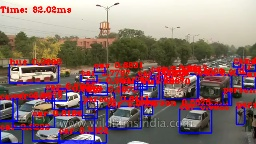

Version: latest-1043-g773bbcaa0
git-773bbcaa0,jerrybdev,2021-09-10T14:12:30+02:00 built 20210914_225200 by  on  ocialtra
Attempt to register kernel  AvgPoolingMeta<FP16[8]>@NEON with priority clashes (priority-wise) with the following kernels:  AvgPoolingMeta<FLOAT[4]>@NEON AvgPoolingMeta<INT8[32]>@NEON 
Attempt to register kernel  MaxPoolingMeta<FP16[8]>@NEON with priority clashes (priority-wise) with the following kernels:  MaxPoolingMeta<FLOAT[4]>@NEON MaxPoolingMeta<INT8[16]>@NEON 
Unknown DLS variable: DLS_ARM64 = "1"
AVX512_ENABLED: 0
DLS_PROCESS_MODE:  1
DLS_NUM_THREADS:  80
CPU_BIND:  1
MEM_BIND:  1
DLS_SUPERNODE 0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
PlatformInfo(vendor_id=3, cpu_family=8, cpu_model=33

In [ ]:
import time
import sys

sys.argv = ['--video', './input_video.mp4']

from absl import app, flags, logging
from absl.flags import FLAGS
import cv2
import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny
)
from yolov3_tf2.dataset import transform_images
from yolov3_tf2.utils import draw_outputs
from IPython.display import clear_output, Image, display, HTML

flags.DEFINE_string('classes', './data/coco.names', 'path to classes file')
flags.DEFINE_string('weights', './checkpoints/yolov3.tf',
                    'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('video', './input_video.mp4',
                    'path to video file or number for webcam)')
flags.DEFINE_string('output', None, 'path to output video')
flags.DEFINE_string('output_format', 'XVID', 'codec used in VideoWriter when saving video to file')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')

def main(argvs):
    config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=80,  inter_op_parallelism_threads=1)
    session = tf.compat.v1.Session(config=config) 
    tf.compat.v1.keras.backend.set_session(session)

    #yolo = YoloV3Tiny(classes=FLAGS.num_classes)
    yolo = YoloV3(classes=FLAGS.num_classes)
    yolo.load_weights(FLAGS.weights)
    print('weights loaded')

    class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
    print('classes loaded')

    times = []

    vid = cv2.VideoCapture('input_video.mp4')

    display_handle = display(None, display_id=True)
    frames = 0
    try:
        while True:
            _, img = vid.read()

            if img is None:
              break

            img_in = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_in = tf.expand_dims(img_in, 0)
            img_in = transform_images(img_in, 416)

            t1 = time.time()
            boxes, scores, classes, nums = yolo.predict(img_in)
            t2 = time.time()
            times.append(t2-t1)
            times = times[-20:]

            img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
            latency = sum(times)/len(times) * 1000
            img = cv2.putText(img, "Time: {:.2f}ms".format(latency), (0, 30),
                   cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
            scale = 0.4
            width = int(img.shape[1] * scale)
            height = int(img.shape[0] * scale)
            img = cv2.resize(img, (width, height))
            _, img = cv2.imencode('.jpeg', img)
            display_handle.update(Image(data=img.tobytes()))
    except KeyboardInterrupt:
        pass
    finally:
        vid.release()
        display_handle.update(None)
    
app.run(main)

